![Crisp](img/logo.png)
# <img src="img/weather.svg" alt="icon" width="40"/>  Weather Analytics with Sales and Inventory data

[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/blueprints/blob/main/notebooks/crisp_weather_analytics.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/blueprints/blob/main/notebooks/crisp_weather_analytics.ipynb)
[![Open in Databricks](https://img.shields.io/badge/Try-databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_weather_analytics.ipynb)

> To deploy a notebook in Databricks:
> 1. Open your workspace and navigate to the folder where you want to import the notebook.
> 2. Click the triple-dot icon (next to the Share button).
> 3. Select Import and choose URL as the import method.
> 4. Paste the notebook's URL and click Import to complete the process.

This notebook demonstrates how to leverage weather data in predicting sales, and finding inventory gaps.

## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "81879"
# os.environ["CONNECTOR_ID"] = "7240"
retailer = "kroger"

### Run Crisp common

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables. The `crisp_common.ipynb` notebook contains the common functions and variables that are used across the Crisp notebooks.

In [ ]:
if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/analytics-blueprints-public/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Import globally used dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

### Load the data from BigQuery

We'll load data from the `fact_sales` and `fact_weather` tables.

In [4]:
dim_product = "exp_harmonized_retailer_dim_product"
dim_store = "exp_harmonized_retailer_dim_store"
fact_sales = "exp_harmonized_retailer_fact_sales"
fact_inventory = "exp_harmonized_retailer_fact_inventory_store"
fact_weather = "exp_harmonized_fact_weather"

In [5]:
%%load date_product_store_sales
WITH
  dim_product AS(
  SELECT
    product_id,
    product,
    product_category,
    product_sub_category
  FROM
    `{project}`.`{dataset}`.`{dim_product}`
  WHERE
    retailer = '{retailer}'
  ),
  fact_sales AS(
  SELECT
    store_id,
    product_id,
    sales_quantity,
    date_key
  FROM
    `{project}`.`{dataset}`.`{fact_sales}`
  WHERE
    retailer = '{retailer}'
  )
SELECT
    dim_product.product_id,
    dim_product.product,
    dim_product.product_category,
    dim_product.product_sub_category,
    fact_sales.store_id,
    fact_sales.date_key,
    SUM(fact_sales.sales_quantity) AS sales_quantity
FROM
    fact_sales
INNER JOIN dim_product USING (product_id)
GROUP BY 1, 2, 3, 4, 5, 6

In [6]:
date_product_store_sales.head()

,product_id,product,product_category,product_sub_category,store_id,date_key,sales_quantity
0,8575722703592916704,ITEM DESC:116,01 GROCERY,None,5252829482435621679,2024-09-01,1.000000000
1,8473123794189420776,ITEM DESC:105,01 GROCERY,None,3026663826360837907,2024-08-23,1.000000000
2,178004471822456568,ITEM DESC:81,01 GROCERY,None,5343224069765634183,2024-07-16,1.000000000
3,3677474752911386298,ITEM DESC:86,01 GROCERY,None,1598241288654580067,2024-10-04,2.000000000
4,5298097253770053933,ITEM DESC:134,01 GROCERY,None,6714147067180665871,2024-10-31,2.000000000


## Load stores information

In [7]:
%%load stores_df
SELECT
    store_id,
    store_zip,
    store_state,
    store_latitude,
    store_longitude
FROM
    `{project}`.`{dataset}`.`{dim_store}`
WHERE
    retailer = '{retailer}'

In [8]:
stores_df = stores_df.dropna()
stores_df

,store_id,store_zip,store_state,store_latitude,store_longitude
16,190792293746137115,37204,TN,36.120937000,-86.767629400
17,215566683812455050,38558,TN,36.008556000,-84.885535000
18,4978005319292262175,81611,CO,39.187390200,-106.816741900
19,6978146565495288864,986641913,WA,45.625324700,-122.584666500
20,3406423202948442897,30305,GA,33.845611300,-84.372901300
...,...,...,...,...,...
2489,8691493947115257530,99645,AK,61.600671600,-149.124494900
2490,7171776820614263821,99654,AK,61.579469700,-149.409224100
2491,1752843632968267178,99669,AK,60.489408000,-151.048852000
2492,1917953251436743450,99701,AK,64.854707900,-147.690414200


## Load products information

In [9]:
%%load products_df
SELECT
    product_id,
    product
FROM
    `{project}`.`{dataset}`.`{dim_product}`

In [10]:
products_df

,product_id,product
0,7292770075319311134,ITEM DESC:43
1,8212929316721228638,ITEM DESC:49
2,3566222428087542888,ITEM DESC:31
3,2987032263541847785,ITEM DESC:47
4,4470742141636198984,ITEM DESC:65
...,...,...
254,4341226654145420738,ITEM DESC:31
255,4341226654145420738,ITEM DESC:31
256,4341226654145420738,ITEM DESC:31
257,6101480349692265330,ITEM DESC:47


## Load weather data

In [11]:
%%load weather_df
SELECT
    date_key,
    store_zip,
    average_temperature_fahrenheit,
    maximum_temperature_fahrenheit,
    minimum_temperature_fahrenheit,
    precipitation_inches,
    pressure_sea_level_millibars,
    relative_humidity_percent,
    sky_coverage_percent,
    snowfall_inches,
    wind_direction_degrees,
    wind_speed_mph,
    wind_gust_mph,
    allergy_index,
    asthma_index,
    flu_index,
    is_forecast
FROM
    `{project}`.`{dataset}`.`{fact_weather}`

## Visualize correlation between weather data columns

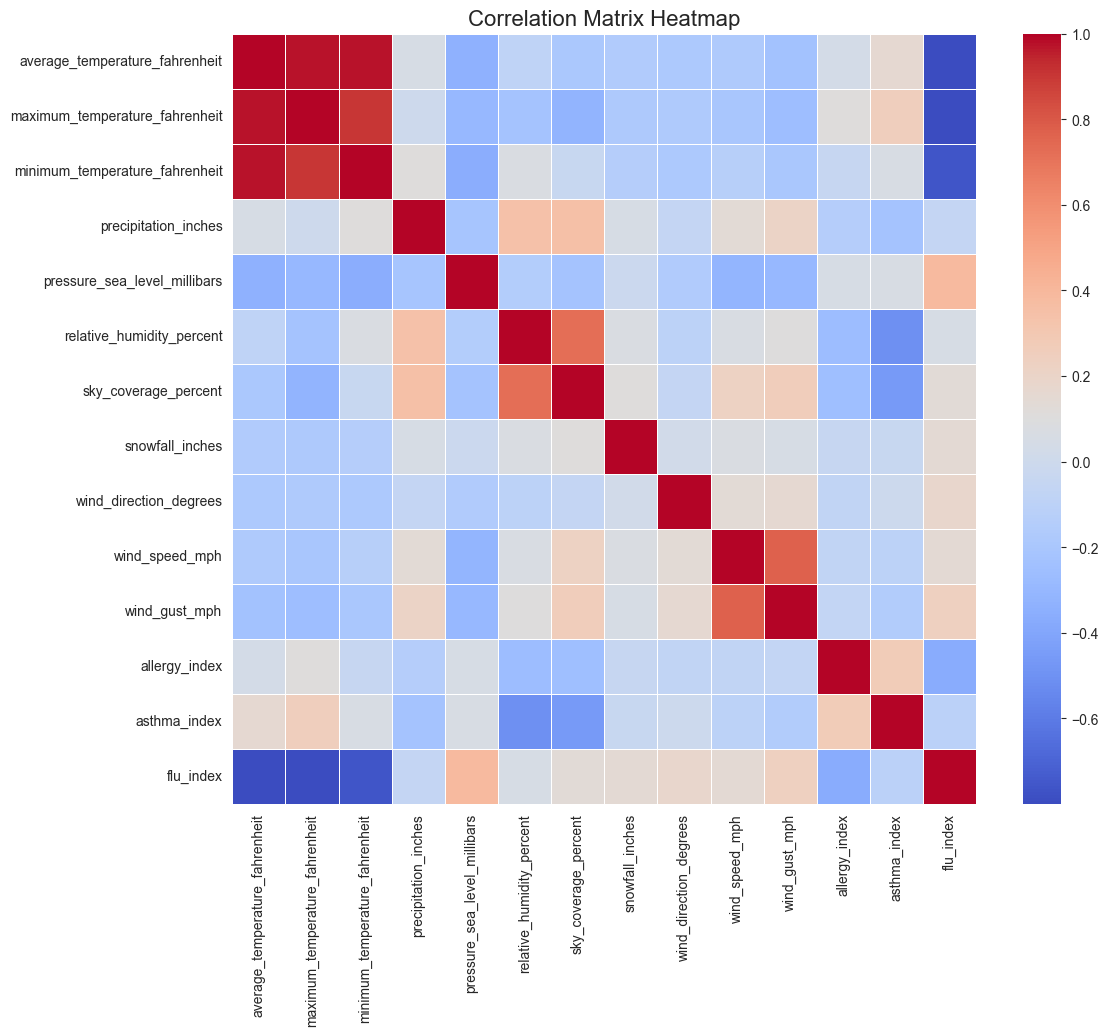

In [12]:
numeric_weather_df = weather_df.select_dtypes(include=[np.number]).drop(
    ["store_zip"], axis=1, errors="ignore"
)

# Calculating the correlation matrix
correlation_matrix = numeric_weather_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

## Combine weather data and sales data

In [13]:
sales_with_stores = date_product_store_sales.merge(stores_df, on="store_id")
weather_df["date_key"] = pd.to_datetime(weather_df["date_key"])
sales_with_stores["date_key"] = pd.to_datetime(sales_with_stores["date_key"])
weather_df["store_zip"] = weather_df["store_zip"].astype(str)
sales_with_stores["store_zip"] = sales_with_stores["store_zip"].astype(str)
sales_weather_df = sales_with_stores.merge(
    weather_df, on=["date_key", "store_zip"], how="inner"
)
sales_weather_df["sales_quantity"] = sales_weather_df["sales_quantity"].fillna(0)
sales_weather_df

,product_id,product,product_category,product_sub_category,store_id,date_key,sales_quantity,store_zip,store_state,store_latitude,...,relative_humidity_percent,sky_coverage_percent,snowfall_inches,wind_direction_degrees,wind_speed_mph,wind_gust_mph,allergy_index,asthma_index,flu_index,is_forecast
0,8575722703592916704,ITEM DESC:116,01 GROCERY,None,5252829482435621679,2024-09-01,1.000000000,85295,AZ,33.290400200,...,13.0,28.0,0.0,100.0,15.0,25.0,0,0,3,False
1,8473123794189420776,ITEM DESC:105,01 GROCERY,None,3026663826360837907,2024-08-23,1.000000000,98272,WA,47.862769300,...,84.0,98.0,0.0,188.0,14.0,8.0,0,0,2,False
2,178004471822456568,ITEM DESC:81,01 GROCERY,None,5343224069765634183,2024-07-16,1.000000000,48044,MI,42.644077300,...,66.0,67.0,0.0,243.0,19.0,29.0,0,4,1,False
3,3677474752911386298,ITEM DESC:86,01 GROCERY,None,1598241288654580067,2024-10-04,2.000000000,38002,TN,35.202581800,...,43.0,17.0,0.0,76.0,9.0,9.0,1,4,1,False
4,5298097253770053933,ITEM DESC:134,01 GROCERY,None,6714147067180665871,2024-10-31,2.000000000,30549,GA,34.122538100,...,47.0,50.0,0.0,155.0,7.0,20.0,10,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840514,2987032263541847785,ITEM DESC:47,CONSTRUCTION,MAGNETIC CONSTRUCT,3964169554784926052,2024-11-10,1.000000000,38501,TN,36.154047100,...,63.0,96.0,0.0,181.0,18.0,30.0,5,0,2,False
5840515,2987032263541847785,ITEM DESC:47,CONSTRUCTION,MAGNETIC CONSTRUCT,1598241288654580067,2024-02-08,6.000000000,38002,TN,35.202581800,...,48.0,79.0,0.0,180.0,29.0,36.0,<NA>,<NA>,<NA>,False
5840516,2987032263541847785,ITEM DESC:47,CONSTRUCTION,MAGNETIC CONSTRUCT,5273094797029179868,2024-10-24,5.000000000,90230,CA,34.001548700,...,54.0,31.0,0.0,140.0,8.0,19.0,0,10,2,False
5840517,2987032263541847785,ITEM DESC:47,CONSTRUCTION,MAGNETIC CONSTRUCT,3752875547249680899,2024-11-29,2.000000000,53226,WI,43.053698400,...,46.0,48.0,0.1,278.0,34.0,35.0,0,1,10,False


## Find correlation between per sub-category sales and weather features

In [14]:
sales_weather_df["category_subcategory"] = (
    sales_weather_df["product_category"]
    + " - "
    + sales_weather_df["product_sub_category"]
)

unique_categories = sales_weather_df["category_subcategory"].unique()
correlation_data = []

for category in unique_categories:
    category_df = sales_weather_df[sales_weather_df["category_subcategory"] == category]

    correlations_prep = category_df[
        [
            "sales_quantity",
            "average_temperature_fahrenheit",
            "maximum_temperature_fahrenheit",
            "minimum_temperature_fahrenheit",
            "precipitation_inches",
            "pressure_sea_level_millibars",
            "relative_humidity_percent",
            "sky_coverage_percent",
            "snowfall_inches",
            "wind_direction_degrees",
            "wind_speed_mph",
            "wind_gust_mph",
            "allergy_index",
            "asthma_index",
            "flu_index",
        ]
    ]

    correlations_prep = correlations_prep.fillna(0).apply(
        pd.to_numeric, errors="coerce"
    )
    all_correlations = correlations_prep.corr()
    if "sales_quantity" in all_correlations.columns:
        correlations = all_correlations["sales_quantity"].drop(["sales_quantity"])
        correlation_data.append(
            {"category_subcategory": category, **correlations.to_dict()}
        )

correlation_df = pd.DataFrame(correlation_data)
pivot_table = correlation_df.set_index("category_subcategory")

## Visualize correlations between sales and weather features

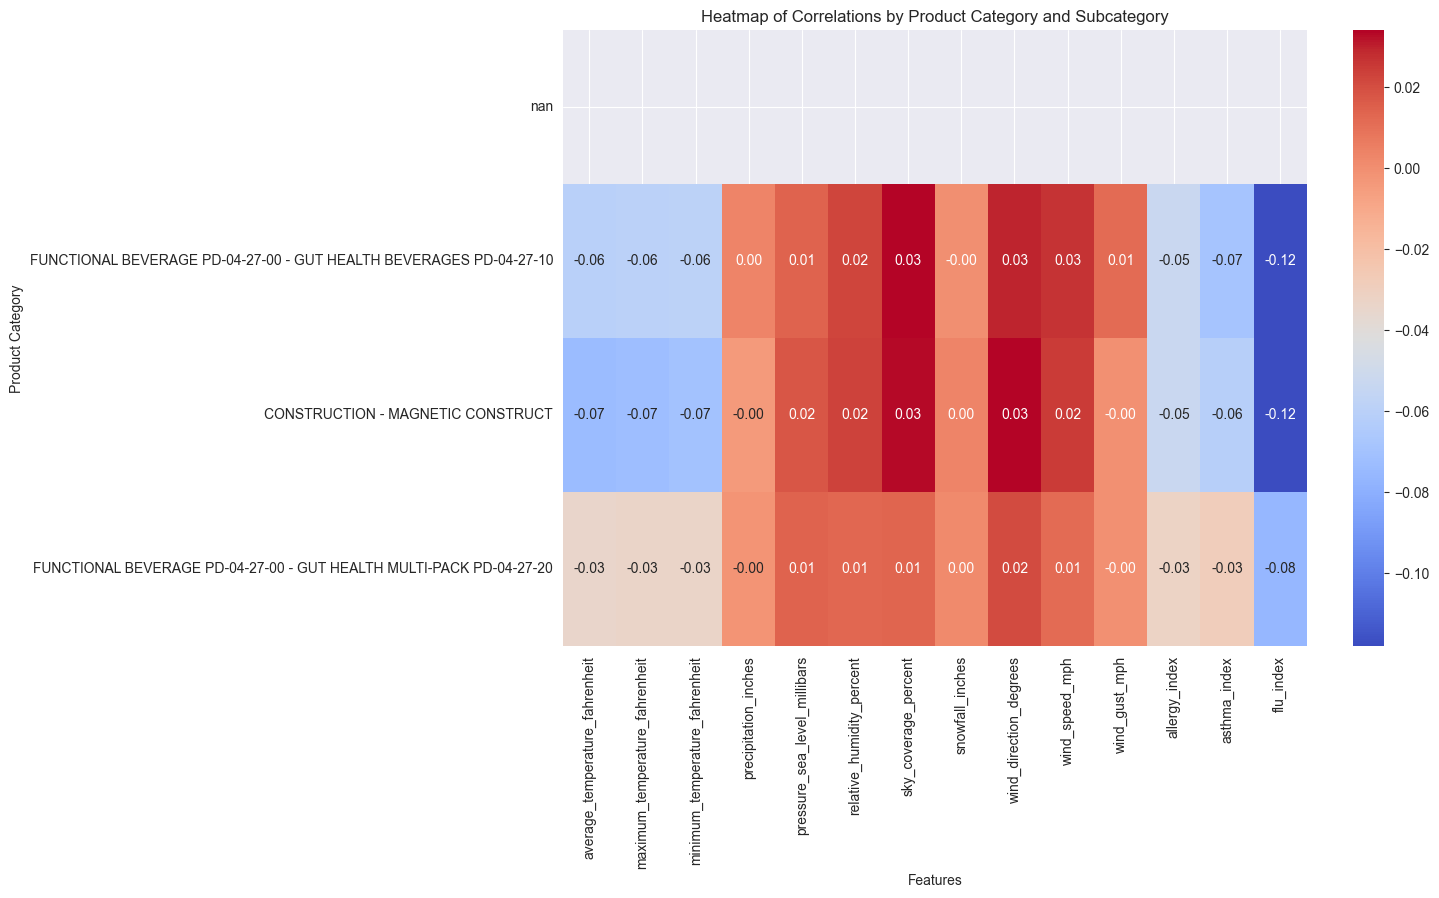

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Correlations by Product Category and Subcategory")
plt.ylabel("Product Category")
plt.xlabel("Features")
plt.show()

# Analyze single category products correlations with weather data

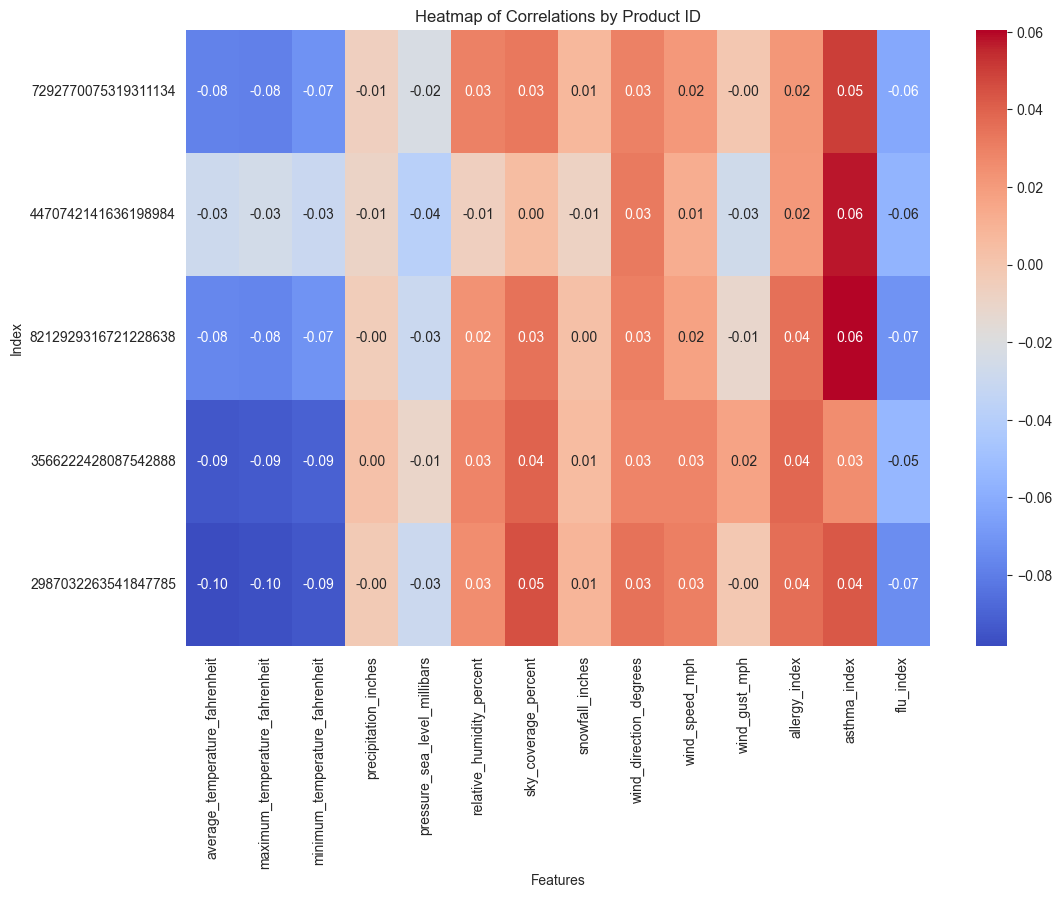

In [16]:
category_df = sales_weather_df[sales_weather_df["product_category"] == "CONSTRUCTION"]
unique_products = category_df["product_id"].unique()

correlation_data = []

for product_id in unique_products:
    # Filter data for the current product
    product_df = category_df[category_df["product_id"] == product_id]

    # Select relevant columns for correlation calculation
    correlations_prep = product_df[
        [
            "sales_quantity",
            "average_temperature_fahrenheit",
            "maximum_temperature_fahrenheit",
            "minimum_temperature_fahrenheit",
            "precipitation_inches",
            "pressure_sea_level_millibars",
            "relative_humidity_percent",
            "sky_coverage_percent",
            "snowfall_inches",
            "wind_direction_degrees",
            "wind_speed_mph",
            "wind_gust_mph",
            "allergy_index",
            "asthma_index",
            "flu_index",
        ]
    ]

    correlations_prep = correlations_prep.apply(pd.to_numeric, errors="coerce")
    correlations = correlations_prep.corr()["sales_quantity"].drop(["sales_quantity"])
    correlation_data.append({"product_id": product_id, **correlations.to_dict()})

correlation_df = pd.DataFrame(correlation_data)

pivot_table = correlation_df.set_index("product_id")

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Correlations by Product ID")
plt.ylabel("Index")
plt.xlabel("Features")
plt.show()

## Create a weather-based sales predictor for each product


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


category_df = sales_weather_df[sales_weather_df["product_category"] == "CONSTRUCTION"]

unique_products = category_df["product_id"].unique()

predictors = {}

for product_id in unique_products:
    product_df = category_df[category_df["product_id"] == product_id].sample(
        frac=0.1
    )  # Sample 10% of the data to speed up training

    feature_columns = [
        "average_temperature_fahrenheit",
        "maximum_temperature_fahrenheit",
        "minimum_temperature_fahrenheit",
        "precipitation_inches",
        "pressure_sea_level_millibars",
        "relative_humidity_percent",
        "sky_coverage_percent",
        "snowfall_inches",
        "wind_direction_degrees",
        "wind_speed_mph",
        "wind_gust_mph",
        "allergy_index",
        "asthma_index",
        "flu_index",
    ]
    X = product_df[feature_columns]
    y = product_df["sales_quantity"]

    X = X.apply(pd.to_numeric, errors="coerce").fillna(0)
    y = pd.to_numeric(y, errors="coerce").fillna(0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    predictors[product_id] = {"model": model, "mse": mse, "r2": r2}

predictors

{7292770075319311134: {'model': RandomForestRegressor(random_state=42),
  'mse': 9.132970368169067,
  'r2': -0.06500410681249225},
 4470742141636198984: {'model': RandomForestRegressor(random_state=42),
  'mse': 11.348611563481619,
  'r2': -0.07350302808143105},
 8212929316721228638: {'model': RandomForestRegressor(random_state=42),
  'mse': 14.80362867217875,
  'r2': -0.04837785103558079},
 3566222428087542888: {'model': RandomForestRegressor(random_state=42),
  'mse': 11.72834827592258,
  'r2': -0.055566222647937424},
 2987032263541847785: {'model': RandomForestRegressor(random_state=42),
  'mse': 17.75533318901285,
  'r2': -0.028851177076629764}}

In [18]:
forecast_data = weather_df[weather_df["is_forecast"]]
forecast_data

,date_key,store_zip,average_temperature_fahrenheit,maximum_temperature_fahrenheit,minimum_temperature_fahrenheit,precipitation_inches,pressure_sea_level_millibars,relative_humidity_percent,sky_coverage_percent,snowfall_inches,wind_direction_degrees,wind_speed_mph,wind_gust_mph,allergy_index,asthma_index,flu_index,is_forecast
91871,2024-12-18,15213,37.22,41.97,32.47,0.28,1022.42,61.0,74.0,0.00,198.0,11.9,19.1,0,0,7,True
91872,2024-12-18,15688,37.02,43.58,30.46,0.30,1022.26,78.0,69.0,0.00,172.0,9.0,17.4,0,0,7,True
91873,2024-12-18,12885,35.17,40.08,30.27,0.13,1021.30,71.0,93.0,0.00,198.0,9.2,20.7,0,0,7,True
91874,2024-12-18,70669,66.15,76.39,55.90,0.09,1022.58,63.0,64.0,0.00,187.0,13.6,27.4,5,0,1,True
91875,2024-12-18,53576,26.70,33.32,20.09,0.04,1028.14,62.0,65.0,0.43,320.0,16.6,21.4,0,0,9,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5479021,2024-12-21,66213,30.75,39.81,21.69,0.00,1029.75,48.0,9.0,0.00,123.0,11.7,17.4,0,8,8,True
5479022,2024-12-21,64024,29.87,38.87,20.87,0.00,1029.92,49.0,19.0,0.00,123.0,12.9,18.2,0,8,9,True
5479023,2024-12-21,67205,33.33,45.83,20.83,0.00,1027.22,47.0,13.0,0.00,140.0,19.0,26.1,0,8,8,True
5479024,2024-12-21,66866,32.41,44.77,20.05,0.00,1027.31,46.0,9.0,0.00,150.0,17.3,24.5,0,8,8,True


## Run predictors on all forecast data

In [19]:
forecasted_sales = {}

feature_columns = [
    "average_temperature_fahrenheit",
    "maximum_temperature_fahrenheit",
    "minimum_temperature_fahrenheit",
    "precipitation_inches",
    "pressure_sea_level_millibars",
    "relative_humidity_percent",
    "sky_coverage_percent",
    "snowfall_inches",
    "wind_direction_degrees",
    "wind_speed_mph",
    "wind_gust_mph",
    "allergy_index",
    "asthma_index",
    "flu_index",
]

X_forecast = forecast_data[feature_columns]
X_forecast = X_forecast.apply(pd.to_numeric, errors="coerce").fillna(0)

for product_id, predictor in predictors.items():
    model = predictor["model"]
    predictions = model.predict(X_forecast)
    forecasted_sales[product_id] = predictions

forecast_results = pd.DataFrame(forecasted_sales)

forecast_results["store_zip"] = forecast_data["store_zip"].values
forecast_results["date_key"] = forecast_data["date_key"].values

forecast_results = forecast_results.melt(
    id_vars=["store_zip", "date_key"],
    var_name="product_id",
    value_name="14d_expected_sales",
)

forecast_results

,store_zip,date_key,product_id,14d_expected_sales
0,15213,2024-12-18,7292770075319311134,2.270
1,15688,2024-12-18,7292770075319311134,2.250
2,12885,2024-12-18,7292770075319311134,2.060
3,70669,2024-12-18,7292770075319311134,3.165
4,53576,2024-12-18,7292770075319311134,3.370
...,...,...,...,...
1048245,66213,2024-12-21,2987032263541847785,1.970
1048246,64024,2024-12-21,2987032263541847785,1.740
1048247,67205,2024-12-21,2987032263541847785,1.700
1048248,66866,2024-12-21,2987032263541847785,1.960


# Prepare expected sales information

In [20]:
forecast_results["store_zip"] = forecast_results["store_zip"].astype(str)
stores_df["store_zip"] = stores_df["store_zip"].astype(str)
forecast_results = forecast_results.merge(stores_df, on="store_zip", how="inner")

# Calculate total expected sales per store and product
sales_by_store = (
    forecast_results.groupby(["store_id", "product_id"])["14d_expected_sales"]
    .sum()
    .reset_index()
)
sales_by_store = sales_by_store[sales_by_store["14d_expected_sales"] > 0]
# Sort by total expected sales in descending order
sales_by_store = sales_by_store.sort_values("14d_expected_sales", ascending=False)

# Display summary of top stores by expected sales
print("\nTop Stores by Expected Sales with Product Detail:")
sales_by_store[["store_id", "product_id", "14d_expected_sales"]]


Top Stores by Expected Sales with Product Detail:


,store_id,product_id,14d_expected_sales
2955,2246775719817634208,2987032263541847785,69.480000
1650,1226629082354862185,2987032263541847785,66.913333
10487,7936602031640287471,4470742141636198984,66.670833
2539,1917953251436743450,8212929316721228638,66.510000
650,481601122819720211,2987032263541847785,64.972500
...,...,...,...
11988,9044192253169877240,7292770075319311134,29.176667
11651,8813445503266964261,3566222428087542888,28.894167
8047,6021000608249243495,4470742141636198984,28.880000
1956,1495002099175161412,3566222428087542888,28.730000


## Load inventory data

In [21]:
%%load inventory_df
SELECT
    date_key,
    store_id,
    product_id,
    on_hand_quantity
FROM
    `{project}`.`{dataset}`.`{fact_inventory}`
WHERE 
    retailer = '{retailer}'
    AND date_key >= DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)

In [22]:
inventory_df = (
    inventory_df.sort_values("date_key").groupby(["store_id", "product_id"]).tail(1)
)
inventory_df

,date_key,store_id,product_id,on_hand_quantity
34433,2024-11-30,1585847818211347878,2987032263541847785,0E-9
34427,2024-11-30,4206527660330045905,2987032263541847785,0E-9
34428,2024-11-30,2441109916725250288,3801454027401068220,0E-9
34429,2024-11-30,4999766757635328001,2987032263541847785,0E-9
34430,2024-11-30,1559204085876032205,2987032263541847785,0E-9
...,...,...,...,...
33447,2024-11-30,7606245908320631653,2987032263541847785,0E-9
33448,2024-11-30,5602759245675467606,2987032263541847785,0E-9
33449,2024-11-30,6192564546378986618,3855004536412381974,0E-9
33440,2024-11-30,5154445481254842603,2987032263541847785,0E-9


## Find inventory gaps at stores

In [25]:
# Merge sales forecast with current inventory levels
sales_by_store["product_id"] = sales_by_store["product_id"].astype(int)
inventory_df["product_id"] = inventory_df["product_id"].astype(int)
inventory_analysis = sales_by_store.merge(
    inventory_df, on=["store_id", "product_id"], how="left"
)

# Fill missing inventory with 0 (stores with no inventory data)
inventory_analysis["on_hand_quantity"] = (
    inventory_analysis["on_hand_quantity"].fillna(0.0).astype(float)
)

# Calculate inventory gap
inventory_analysis["inventory_gap"] = (
    inventory_analysis["on_hand_quantity"] - inventory_analysis["14d_expected_sales"]
)

# Filter to show only stores with insufficient inventory
insufficient_inventory = inventory_analysis[
    inventory_analysis["inventory_gap"] < -1
].sort_values("inventory_gap")
# Add product names to the analysis
insufficient_inventory = insufficient_inventory.merge(
    products_df[["product_id", "product"]], on="product_id", how="left"
)

print("\nStores with Insufficient Inventory:")
insufficient_inventory[
    [
        "store_id",
        "product_id",
        "product",
        "on_hand_quantity",
        "14d_expected_sales",
        "inventory_gap",
    ]
]


Stores with Insufficient Inventory:


,store_id,product_id,product,on_hand_quantity,14d_expected_sales,inventory_gap
0,2246775719817634208,2987032263541847785,ITEM DESC:47,0.0,69.480000,-69.480000
1,1226629082354862185,2987032263541847785,ITEM DESC:47,0.0,66.913333,-66.913333
2,7936602031640287471,4470742141636198984,ITEM DESC:65,0.0,66.670833,-66.670833
3,1917953251436743450,8212929316721228638,ITEM DESC:49,0.0,66.510000,-66.510000
4,481601122819720211,2987032263541847785,ITEM DESC:47,0.0,64.972500,-64.972500
...,...,...,...,...,...,...
12265,9044192253169877240,7292770075319311134,ITEM DESC:43,0.0,29.176667,-29.176667
12266,8813445503266964261,3566222428087542888,ITEM DESC:31,0.0,28.894167,-28.894167
12267,6021000608249243495,4470742141636198984,ITEM DESC:65,0.0,28.880000,-28.880000
12268,1495002099175161412,3566222428087542888,ITEM DESC:31,0.0,28.730000,-28.730000


## Visualize inventory gaps

In [24]:
# Map the stores with insufficient inventory; make the size of the marker proportional to the inventory gap
insufficient_inventory_with_location = insufficient_inventory.merge(
    stores_df[["store_id", "store_latitude", "store_longitude"]],
    on="store_id",
    how="left",
)
m = folium.Map(location=[37, -95], zoom_start=5)


for _, row in insufficient_inventory_with_location.sample(frac=0.01).iterrows():
    folium.CircleMarker(
        location=[row["store_latitude"], row["store_longitude"]],
        radius=0.3 * abs(row["inventory_gap"]),
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.3,
        popup=f"Store ID: {row['store_id']}<br>Product: {row['product']}<br>Inventory Gap: {row['inventory_gap']:.2f}",
    ).add_to(m)

m